In [26]:
 #load package
using Revise
using Plots
using LaTeXStrings
using LinearAlgebra
using SparseIR
using Nevanlinna

In [27]:
BLAS.get_num_threads()

8

In [28]:
BLAS.set_num_threads(8)

In [29]:
# Set work data Type
T = BigFloat
setprecision(2048)

2048

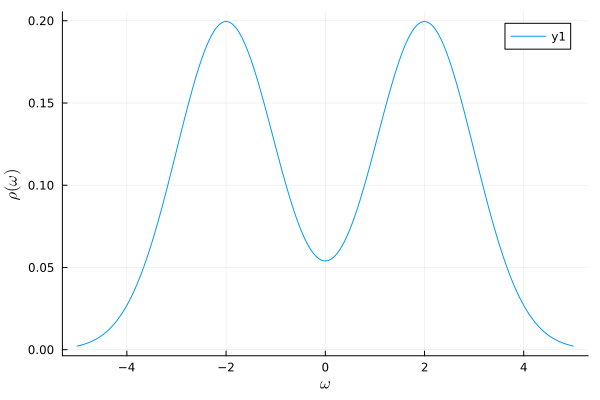

In [30]:
 #define spectral function
gaussian(x, mu, sigma) = exp(-0.5*((x-mu)/sigma)^2)/(sqrt(2*π)*sigma)
#rho(omega) = gaussian(omega, 0.0, 1.0)
rho(omega) = 0.5*gaussian(omega, 2.0, 1.0) + 0.5*gaussian(omega, -2.0, 1.0)
omegas = LinRange(-5, 5, 1000)
plot()
plot!(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [31]:
beta = 100
lambda = 1e+4
    wmax = lambda/beta
    basis = FiniteTempBasisSet(beta, wmax, 1e-15)

FiniteTempBasisSet with β = 100.0, ωmax = 100.0

In [32]:
 rhol = [overlap(basis.basis_f.v[l], rho) for l in 1:length(basis.basis_f)]

104-element Vector{Float64}:
  0.20874344883234397
 -2.3201926491189795e-17
  0.08836844982245871
  1.1655173354219173e-18
 -0.15927416557982976
 -4.580754178751256e-18
 -0.11959052878224571
  1.3010426069826053e-18
  0.11501566923019049
  8.998878031629687e-18
  0.10422589736647803
 -1.7889335846010823e-18
 -0.08949931950525508
  ⋮
 -1.2163504837653925e-6
 -4.553649124439119e-18
 -4.269047915245227e-6
  7.589415207398531e-19
  1.9012724432516687e-6
  5.2583805365546965e-18
  1.7331516563965526e-6
 -3.848917712323541e-18
 -1.5288213906097608e-6
  5.4752209710517974e-18
 -4.68833309242786e-7
 -4.716279450311944e-18

In [33]:
gl = - basis.basis_f.s .* rhol
gw = evaluate(basis.smpl_wn_f, gl)

104-element Vector{ComplexF64}:
   -6.89959748850982e-21 + 0.0007035854607868745im
  -9.659763479063893e-19 + 0.0021247093068828063im
   5.012796361406868e-19 + 0.0035879765176723404im
   6.542274993892541e-19 + 0.005122615813512983im
  -7.027026470000865e-19 + 0.006758063138993284im
   3.593691461683838e-18 + 0.008523821043441425im
 -2.2703982879500616e-18 + 0.010461547975864207im
  -7.357642955292777e-18 + 0.012606298166943563im
   5.983315821995962e-19 + 0.01499067044095433im
 -3.0849417705535822e-18 + 0.017685690414146783im
 -1.1059485163252356e-17 + 0.020719259025146555im
   5.917331060482992e-19 + 0.02413551411283625im
  1.1371884794756487e-17 + 0.028033399097543467im
                         ⋮
   5.917331060482992e-19 - 0.02413551411283625im
 -1.1059485163252356e-17 - 0.020719259025146555im
 -3.0849417705535822e-18 - 0.017685690414146783im
   5.983315821995962e-19 - 0.01499067044095433im
  -7.357642955292777e-18 - 0.012606298166943563im
 -2.2703982879500616e-18 - 0.0104615479758

In [51]:
gw_ref = basis.smpl_wn_f.matrix * gl
    @show maximum(abs, gw .- gw_ref)

maximum(abs, gw .- gw_ref) = 2.220446049250313e-16


2.220446049250313e-16

In [52]:
sum(basis.smpl_wn_f.matrix)

-42.502400120139555 + 6.4186801488145026e-15im

In [34]:
function generate_input_data(rho::Function, beta::Float64)
    lambda = 1e+4
    wmax = lambda/beta
    basis = FiniteTempBasisSet(beta, wmax, 1e-15)

    rhol = [overlap(basis.basis_f.v[l], rho) for l in 1:length(basis.basis_f)]
    gl = - basis.basis_f.s .* rhol
    gw = evaluate(basis.smpl_wn_f, gl)
    
    hnw = length(basis.smpl_wn_f.sampling_points)÷2
    
    input_smpl = Array{Complex{T}}(undef, hnw) 
    input_gw   = Array{Complex{T}}(undef, hnw) 
    
    for i in 1:hnw
        input_smpl[i]= SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], beta)
        input_gw[i]  = gw[hnw+i]
    end
    
    return input_smpl, input_gw
end

generate_input_data (generic function with 1 method)

In [35]:
beta = 100. #inverse temperature
input_smpl, input_gw = generate_input_data(rho, beta)
;

In [38]:
N_real    = 1000  #demension of array of output
omega_max = 10.0  #energy cutoff of real axis
eta       = 0.001 #broaden parameter 
sum_rule  = 1.0   #sum rule
H_max     = 50    #cutoff of Hardy basis
lambda    = 1e-4  #regularization parameter
iter_tol  = 1000  #upper bound of iteration
;

In [39]:
#moments = Complex{T}.([1, 0, 1, 0, 3, 0, 15, 0, 105, 0, 945])
#moments = Complex{T}.([1, 0, 1])
#moments = Complex{T}.([1])

#moments = Complex{T}.([1, 0, 5, 0, 43, 0, 499, 0, 7193, 0, 123109, 0, 2430355, 0, 54229907])
moments = Complex{T}.([1, 0, 5, 0, 43])

5-element Vector{Complex{BigFloat}}:
  1.0 + 0.0im
  0.0 + 0.0im
  5.0 + 0.0im
  0.0 + 0.0im
 43.0 + 0.0im

In [40]:
wo_ham_nev_sol = Nevanlinna.HamburgerNevanlinnaSolver(moments, input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true, optimization=false)
;

Rank of Hankel matrix:3
Non-degenerate
Postive semi-definite
Non-singular
Positive definite
Proper
N_imag is setted as 30


In [41]:
#ham_nev_sol = Nevanlinna.HamburgerNevanlinnaSolver(moments, input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true, optimization=true)
;

In [42]:
#Nevanlinna.solve!(ham_nev_sol)

In [43]:
wo_sol = Nevanlinna.NevanlinnaSolver(input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true, optimization=false)
;

N_imag is setted as 33


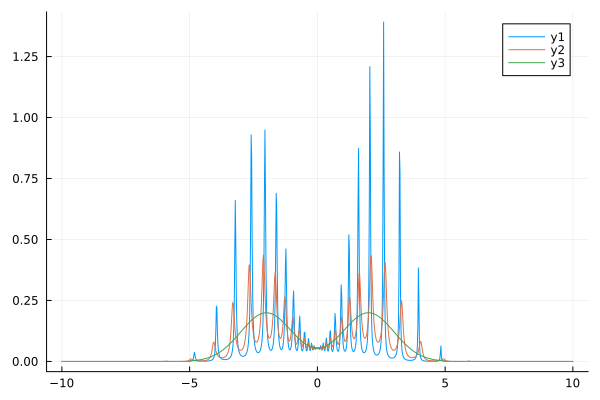

In [44]:
plot()
plot!(real.(wo_sol.reals.freq), imag.(wo_sol.reals.val)/pi)
plot!(Float64.(real.((wo_ham_nev_sol.nev_st.reals.freq))), Float64.(imag.(wo_ham_nev_sol.val))/pi)
#plot!(Float64.(real.((ham_nev_sol.nev_st.reals.freq))), Float64.(imag.(ham_nev_sol.val))/pi)
plot!(omegas, rho.(omegas))

In [45]:
function calc_moment_k(x::AbstractVector, y::AbstractVector,k::Int64)
    N = length(x)
    dx = view(x, 2:N) .- view(x, 1:(N-1))
    
    xk = x.^(k-1)
    
    y = y .* xk
    
    y_forward = view(y, 2:N)
    y_backward = view(y, 1:(N-1))
    return sum(0.5 * (y_forward .+ y_backward) .* dx)
end

calc_moment_k (generic function with 1 method)

In [46]:
calc_moment_k(real.((wo_ham_nev_sol.nev_st.reals.freq)), Float64.(imag.(wo_ham_nev_sol.val))/pi, 5)

43.29314202987844891796033918579423658595174328930257115536814820935927757812809905764460511860303789309698916483566273526265874921736095160921780372547335484617741739148312379273810766190660500909521749562864355786383597605827376635394875830886986836564776457257905691468203757837386602691509551732451654970645904541015625

In [47]:
cut = 5
calc_moment = Vector{Float64}(undef,5)
for i in 1:cut
    calc_moment[i] = Float64(calc_moment_k(real.((wo_ham_nev_sol.nev_st.reals.freq)), Float64.(imag.(wo_ham_nev_sol.val))/pi, i))
end

In [48]:
moments

5-element Vector{Complex{BigFloat}}:
  1.0 + 0.0im
  0.0 + 0.0im
  5.0 + 0.0im
  0.0 + 0.0im
 43.0 + 0.0im

In [49]:
calc_moment 

5-element Vector{Float64}:
  0.9999328252706802
  2.1117052430510528e-10
  5.005359475447759
 -8.294576805137473e-9
 43.293142029878446